# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_177  P69905            16.101
Sample_159  Q5FWE3;Q5FWE3-3   18.190
Sample_138  P01024            22.839
Sample_208  P05452            17.947
Sample_192  O94910;O94910-2   16.409
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups               
Sample_051  Q9UN36;Q9UN36-3                 16.544
Sample_050  I3L397;I3L504;P63241;P63241-2   11.705
Sample_095  O43581-2;O43581-3;O43581-5      13.633
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.819
            A0A075B6Q5                 12.608
            A0A075B6R2                 11.505
            A0A075B6S5                 13.259
            A0A087WSY4                 13.354
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.517
            Q9UI40;Q9UI40-2            11.384
            Q9UIW2                     11.896
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.612
            Q9UP79                     13.872
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.134,15.050,16.842,19.863,15.760,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.528,19.067,...,15.528,15.576,14.145,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.582,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.642,17.705,17.039,15.903,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.562,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.424,15.345,17.084,18.708,14.249,19.433,12.270,11.437
Sample_207,15.739,16.877,15.469,16.898,14.996,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.819,...,16.012,15.178,12.394,15.050,16.842,19.863,12.920,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.989,19.067,16.188,...,15.528,15.576,14.506,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.212,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.986,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.019,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.337,15.345,17.084,18.708,14.249,19.433,12.764,13.320
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 402.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.71it/s]

100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.73it/s]

100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.55it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.36it/s]

100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.85it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.05it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.37it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.68it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.18it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.49it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.24it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.08it/s]

100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.49it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.92it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.40it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.19it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.07it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.99it/s]

100%|██████████| 8/8 [00:02<00:00,  2.87it/s]

100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.14it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.98it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.99it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.43it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.28it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.95it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.12it/s]

100%|██████████| 9/9 [00:02<00:00,  3.13it/s]

100%|██████████| 9/9 [00:02<00:00,  3.35it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.74it/s]

 30%|███       | 3/10 [00:00<00:01,  4.17it/s]

 40%|████      | 4/10 [00:01<00:01,  3.50it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.19it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.19it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.96it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.92it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.96it/s]

100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.49it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.81it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.40it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.11it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.00it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.96it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.05it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.93it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.82it/s]

100%|██████████| 11/11 [00:03<00:00,  2.82it/s]

100%|██████████| 11/11 [00:03<00:00,  3.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.01it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.56it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.32it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.47it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.28it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.16it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.15it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.23it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.32it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.46it/s]

100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

100%|██████████| 12/12 [00:04<00:00,  2.55it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.99it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.52it/s]

 31%|███       | 4/13 [00:01<00:02,  3.38it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.23it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.07it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.09it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.74it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.50it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.12it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.01it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  1.96it/s]

100%|██████████| 13/13 [00:05<00:00,  1.91it/s]

100%|██████████| 13/13 [00:05<00:00,  2.43it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.88it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.64it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.46it/s]

 36%|███▌      | 5/14 [00:02<00:03,  2.27it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.47it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.41it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.29it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.23it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.07it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.14it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.26it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.17it/s]

100%|██████████| 14/14 [00:06<00:00,  2.10it/s]

100%|██████████| 14/14 [00:06<00:00,  2.28it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.41it/s]

 20%|██        | 3/15 [00:01<00:05,  2.30it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.39it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.58it/s]

 40%|████      | 6/15 [00:02<00:03,  2.36it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.26it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.13it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.10it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.14it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.14it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.23it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.35it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.39it/s]

100%|██████████| 15/15 [00:06<00:00,  2.43it/s]

100%|██████████| 15/15 [00:06<00:00,  2.33it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.051 0.017          0.793 0.319       0.124   
2             0.004 0.002      0.049 0.009          0.756 0.092       0.714   
3             0.004 0.002      0.050 0.011          0.749 0.092       0.712   
4             0.004 0.002      0.049 0.010          0.786 0.100       0.778   
5             0.004 0.002      0.049 0.011          0.778 0.096       0.776   
6             0.004 0.000      0.047 0.003          0.809 0.091       0.802   
7             0.004 0.000      0.047 0.003          0.811 0.089       0.807   
8             0.004 0.000      0.046 0.001          0.808 0.081       0.802   
9             0.004 0.000      0.049 0.007          0.806 0.079       0.794   
10            0.005 0.003      0.062 0.025          0.806 0.085       0.793   
11            0.005 0.004      0.055 0.020          0.802 0.085       0.796   
12            0.005 0.002      0.053 0.015          0.796 0.084       0.789   
13            0.006 0.006      0.073 0.031          0.790 0.084       0.786   
14            0.005 0.003      0.063 0.022          0.802 0.078       0.783   
15            0.006 0.004      0.057 0.018          0.809 0.090       0.786   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.207 0.121                  0.554 0.039        0.855   
2          0.100   0.726 0.060                  0.768 0.047        0.861   
3          0.092   0.725 0.070                  0.766 0.057        0.860   
4          0.094   0.777 0.074                  0.809 0.063        0.894   
5          0.091   0.772 0.068                  0.804 0.058        0.898   
6          0.097   0.800 0.069                  0.829 0.058        0.914   
7          0.097   0.804 0.068                  0.832 0.058        0.912   
8          0.095   0.801 0.066                  0.830 0.056        0.911   
9          0.097   0.796 0.069                  0.826 0.058        0.910   
10         0.097   0.795 0.071                  0.825 0.060        0.908   
11         0.103   0.795 0.074                  0.825 0.062        0.907   
12         0.102   0.788 0.073                  0.819 0.061        0.905   
13         0.098   0.783 0.071                  0.815 0.060        0.904   
14         0.097   0.788 0.068                  0.820 0.057        0.906   
15         0.092   0.793 0.069                  0.823 0.057        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.824 0.091        210.000 0.000  
2          0.056                  0.837 0.066        210.000 0.000  
3          0.053                  0.839 0.061        210.000 0.000  
4          0.049                  0.877 0.058        210.000 0.000  
5          0.047                  0.882 0.052        210.000 0.000  
6          0.046                  0.899 0.052        210.000 0.000  
7          0.049                  0.897 0.054        210.000 0.000  
8          0.049                  0.897 0.054        210.000 0.000  
9          0.049                  0.896 0.054        210.000 0.000  
10         0.049                  0.894 0.054        210.000 0.000  
11         0.050                  0.893 0.055        210.000 0.000  
12         0.050                  0.890 0.056        210.000 0.000  
13         0.050                  0.890 0.054        210.000 0.000  
14         0.050                  0.890 0.055        210.000 0.000  
15         0.047                  0.894 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 500.87it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.12it/s]

100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.20it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.36it/s]

100%|██████████| 4/4 [00:01<00:00,  1.98it/s]

100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.15it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.28it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.92it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.31it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.21it/s]

100%|██████████| 6/6 [00:02<00:00,  1.85it/s]

100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.78it/s]

 43%|████▎     | 3/7 [00:01<00:02,  1.90it/s]

 57%|█████▋    | 4/7 [00:02<00:01,  1.74it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.74it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.90it/s]

100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.98it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.97it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.56it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.02it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.71it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.63it/s]

100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.61it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.36it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.80it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.32it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.97it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.90it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.94it/s]

100%|██████████| 9/9 [00:04<00:00,  2.06it/s]

100%|██████████| 9/9 [00:04<00:00,  2.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.12it/s]

 30%|███       | 3/10 [00:00<00:02,  2.85it/s]

 40%|████      | 4/10 [00:01<00:02,  2.62it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.01it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.96it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.77it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.86it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.97it/s]

100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.52it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.29it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.92it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.60it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.11it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.62it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.47it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.43it/s]

100%|██████████| 11/11 [00:05<00:00,  1.60it/s]

100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  3.11it/s]

 25%|██▌       | 3/12 [00:01<00:04,  2.11it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.02it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.06it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.20it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.07it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.90it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.79it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.75it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.86it/s]

100%|██████████| 12/12 [00:06<00:00,  1.93it/s]

100%|██████████| 12/12 [00:06<00:00,  1.98it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.48it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.95it/s]

 31%|███       | 4/13 [00:01<00:03,  2.32it/s]

 38%|███▊      | 5/13 [00:02<00:04,  2.00it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.81it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.90it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.88it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.74it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.69it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.72it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.67it/s]

100%|██████████| 13/13 [00:06<00:00,  1.78it/s]

100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.88it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.97it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.63it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.66it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.15it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.00it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.92it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.75it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.69it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.66it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.61it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.77it/s]

100%|██████████| 14/14 [00:07<00:00,  1.90it/s]

100%|██████████| 14/14 [00:07<00:00,  1.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.40it/s]

 20%|██        | 3/15 [00:00<00:03,  3.94it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.24it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.06it/s]

 40%|████      | 6/15 [00:01<00:03,  2.96it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.92it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.48it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.07it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.81it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.64it/s]

 80%|████████  | 12/15 [00:05<00:02,  1.50it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.40it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.51it/s]

100%|██████████| 15/15 [00:07<00:00,  1.52it/s]

100%|██████████| 15/15 [00:07<00:00,  1.96it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.066 0.030          0.000 0.000       0.000   
2             0.007 0.008      0.064 0.033          0.656 0.126       0.438   
3             0.007 0.007      0.085 0.046          0.727 0.115       0.548   
4             0.007 0.007      0.081 0.029          0.768 0.098       0.558   
5             0.007 0.006      0.078 0.030          0.773 0.093       0.663   
6             0.005 0.003      0.078 0.034          0.754 0.092       0.696   
7             0.007 0.006      0.073 0.031          0.759 0.092       0.707   
8             0.007 0.005      0.074 0.031          0.818 0.086       0.766   
9             0.007 0.005      0.078 0.028          0.818 0.086       0.783   
10            0.007 0.006      0.064 0.023          0.817 0.086       0.787   
11            0.004 0.002      0.058 0.020          0.811 0.084       0.782   
12            0.007 0.007      0.074 0.032          0.805 0.086       0.771   
13            0.006 0.005      0.073 0.030          0.819 0.085       0.774   
14            0.008 0.006      0.084 0.033          0.850 0.081       0.815   
15            0.006 0.004      0.064 0.027          0.837 0.074       0.816   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.854   
2          0.129   0.514 0.112                  0.633 0.062        0.712   
3          0.124   0.616 0.103                  0.696 0.069        0.751   
4          0.110   0.638 0.082                  0.715 0.053        0.767   
5          0.116   0.707 0.088                  0.758 0.064        0.867   
6          0.111   0.717 0.078                  0.762 0.061        0.868   
7          0.119   0.725 0.082                  0.769 0.063        0.875   
8          0.102   0.787 0.073                  0.819 0.060        0.913   
9          0.104   0.796 0.076                  0.827 0.063        0.912   
10         0.106   0.797 0.077                  0.828 0.064        0.910   
11         0.104   0.792 0.077                  0.823 0.064        0.911   
12         0.099   0.784 0.076                  0.816 0.063        0.911   
13         0.102   0.792 0.076                  0.823 0.063        0.912   
14         0.088   0.830 0.072                  0.854 0.060        0.921   
15         0.103   0.823 0.071                  0.849 0.059        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.827 0.088        210.000 0.000  
2          0.073                  0.664 0.092        210.000 0.000  
3          0.075                  0.700 0.099        210.000 0.000  
4          0.070                  0.742 0.094        210.000 0.000  
5          0.048                  0.839 0.061        210.000 0.000  
6          0.048                  0.834 0.062        210.000 0.000  
7          0.050                  0.832 0.073        210.000 0.000  
8          0.045                  0.895 0.053        210.000 0.000  
9          0.049                  0.896 0.054        210.000 0.000  
10         0.049                  0.894 0.054        210.000 0.000  
11         0.047                  0.896 0.052        210.000 0.000  
12         0.046                  0.895 0.052        210.000 0.000  
13         0.046                  0.898 0.050        210.000 0.000  
14         0.044                  0.912 0.046        210.000 0.000  
15         0.042                  0.912 0.043 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 923.45it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.69it/s]

100%|██████████| 2/2 [00:00<00:00, 19.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.87it/s]

100%|██████████| 3/3 [00:00<00:00, 17.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.08it/s]

100%|██████████| 4/4 [00:00<00:00, 18.59it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.72it/s]

100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 17.65it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 10.12it/s]

100%|██████████| 6/6 [00:00<00:00,  9.77it/s]

100%|██████████| 6/6 [00:00<00:00, 10.08it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.68it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.63it/s]

100%|██████████| 7/7 [00:00<00:00, 10.45it/s]

100%|██████████| 7/7 [00:00<00:00, 11.27it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 18.01it/s]

 50%|█████     | 4/8 [00:00<00:00, 10.60it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  8.60it/s]

 88%|████████▊ | 7/8 [00:00<00:00,  8.48it/s]

100%|██████████| 8/8 [00:00<00:00,  8.26it/s]

100%|██████████| 8/8 [00:00<00:00,  8.92it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.64it/s]

 44%|████▍     | 4/9 [00:00<00:00,  9.41it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  9.40it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  8.33it/s]

100%|██████████| 9/9 [00:01<00:00,  8.04it/s]

100%|██████████| 9/9 [00:01<00:00,  8.62it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 17.18it/s]

 40%|████      | 4/10 [00:00<00:00, 12.04it/s]

 60%|██████    | 6/10 [00:00<00:00,  9.44it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.54it/s]

100%|██████████| 10/10 [00:01<00:00,  9.49it/s]

100%|██████████| 10/10 [00:01<00:00,  9.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 17.83it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.33it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.92it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.97it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  8.87it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.87it/s]

100%|██████████| 11/11 [00:01<00:00,  8.59it/s]

100%|██████████| 11/11 [00:01<00:00,  9.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.14it/s]

 33%|███▎      | 4/12 [00:00<00:00, 11.23it/s]

 50%|█████     | 6/12 [00:00<00:00, 12.30it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 12.32it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.18it/s]

100%|██████████| 12/12 [00:00<00:00, 11.87it/s]

100%|██████████| 12/12 [00:00<00:00, 12.15it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 17.17it/s]

 31%|███       | 4/13 [00:00<00:01,  8.03it/s]

 46%|████▌     | 6/13 [00:00<00:00,  8.67it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  8.59it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  8.74it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.37it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.05it/s]

100%|██████████| 13/13 [00:01<00:00,  8.80it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.96it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.15it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.80it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.35it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.74it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.83it/s]

100%|██████████| 14/14 [00:01<00:00, 12.34it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.65it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.90it/s]

 40%|████      | 6/15 [00:00<00:00, 10.00it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.42it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.85it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.37it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.28it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.30it/s]

100%|██████████| 15/15 [00:01<00:00,  9.18it/s]

100%|██████████| 15/15 [00:01<00:00,  9.24it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.083 0.037          0.000 0.000       0.000   
2             0.004 0.002      0.057 0.020          0.641 0.157       0.414   
3             0.007 0.009      0.078 0.029          0.638 0.151       0.387   
4             0.005 0.003      0.061 0.024          0.686 0.108       0.459   
5             0.006 0.005      0.070 0.026          0.660 0.122       0.445   
6             0.005 0.003      0.062 0.025          0.706 0.112       0.551   
7             0.005 0.003      0.071 0.029          0.694 0.106       0.534   
8             0.005 0.003      0.070 0.027          0.690 0.118       0.528   
9             0.006 0.004      0.072 0.029          0.688 0.108       0.591   
10            0.005 0.004      0.064 0.022          0.673 0.114       0.576   
11            0.005 0.003      0.069 0.027          0.681 0.097       0.617   
12            0.007 0.006      0.077 0.025          0.698 0.103       0.635   
13            0.005 0.002      0.064 0.025          0.695 0.097       0.620   
14            0.008 0.006      0.079 0.032          0.684 0.101       0.613   
15            0.006 0.004      0.062 0.019          0.701 0.090       0.651   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.719   
2          0.108   0.493 0.105                  0.616 0.071        0.682   
3          0.131   0.471 0.126                  0.612 0.070        0.697   
4          0.106   0.542 0.092                  0.651 0.056        0.705   
5          0.115   0.523 0.098                  0.636 0.061        0.706   
6          0.102   0.612 0.085                  0.688 0.065        0.785   
7          0.101   0.597 0.080                  0.678 0.060        0.780   
8          0.112   0.590 0.091                  0.674 0.066        0.777   
9          0.129   0.628 0.097                  0.695 0.073        0.784   
10         0.134   0.612 0.102                  0.683 0.078        0.778   
11         0.123   0.638 0.082                  0.700 0.062        0.798   
12         0.118   0.656 0.081                  0.713 0.063        0.800   
13         0.117   0.646 0.080                  0.707 0.058        0.802   
14         0.116   0.638 0.083                  0.700 0.060        0.795   
15         0.123   0.668 0.088                  0.723 0.066        0.803   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.677 0.083        210.000 0.000  
2          0.079                  0.648 0.091        210.000 0.000  
3          0.075                  0.653 0.090        210.000 0.000  
4          0.072                  0.669 0.086        210.000 0.000  
5          0.071                  0.659 0.088        210.000 0.000  
6          0.065                  0.746 0.083        210.000 0.000  
7          0.067                  0.740 0.085        210.000 0.000  
8          0.072                  0.736 0.089        210.000 0.000  
9          0.068                  0.735 0.088        210.000 0.000  
10         0.073                  0.732 0.094        210.000 0.000  
11         0.064                  0.742 0.088        210.000 0.000  
12         0.067                  0.744 0.093        210.000 0.000  
13         0.066                  0.746 0.093        210.000 0.000  
14         0.066                  0.742 0.093        210.000 0.000  
15         0.064                  0.748 0.091 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,14,14
score_time,13,3,1
test_precision,7,14,6
test_recall,7,15,15
test_f1,7,14,15
test_balanced_accuracy,7,14,15
test_roc_auc,6,15,15
test_average_precision,6,14,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.73it/s]

 20%|██        | 3/15 [00:00<00:03,  3.63it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.28it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.48it/s]

 40%|████      | 6/15 [00:02<00:04,  2.17it/s]

 47%|████▋     | 7/15 [00:02<00:04,  2.00it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.99it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.13it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.20it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.06it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.87it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.68it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.61it/s]

100%|██████████| 15/15 [00:07<00:00,  1.62it/s]

100%|██████████| 15/15 [00:07<00:00,  2.02it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.01it/s]

 40%|████      | 6/15 [00:00<00:00, 11.36it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.94it/s]

 67%|██████▋   | 10/15 [00:00<00:00,  9.50it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.37it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.53it/s]

100%|██████████| 15/15 [00:01<00:00,  8.54it/s]

100%|██████████| 15/15 [00:01<00:00,  9.70it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.16it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.86it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.69it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.80it/s]

100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


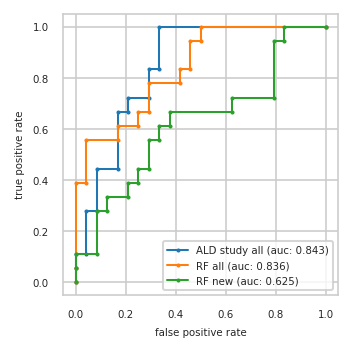

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.111  0.000 0.389  0.000 0.111
3          0.042 0.111  0.042 0.389  0.083 0.111
4          0.042 0.278  0.042 0.556  0.083 0.278
5          0.083 0.278  0.167 0.556  0.125 0.278
6          0.083 0.444  0.167 0.611  0.125 0.333
7          0.167 0.444  0.250 0.611  0.208 0.333
8          0.167 0.667  0.250 0.667  0.208 0.389
9          0.208 0.667  0.292 0.667  0.250 0.389
10         0.208 0.722  0.292 0.778  0.250 0.444
11         0.292 0.722  0.417 0.778  0.292 0.444
12         0.292 0.833  0.417 0.833  0.292 0.556
13         0.333 0.833  0.458 0.833  0.333 0.556
14         0.333 1.000  0.458 0.944  0.333 0.611
15         1.000 1.000  0.500 0.944  0.375 0.611
16           NaN   NaN  0.500 1.000  0.375 0.667
17           NaN   NaN  1.000 1.000  0.625 0.667
18           NaN   NaN    NaN   NaN  0.625 0.722
19           NaN   NaN    NaN   NaN  0.792 0.722
20           NaN   NaN    NaN   NaN  0.792 0.944
21           NaN   NaN    NaN   NaN  0.833 0.944
22           NaN   NaN    NaN   NaN  0.833 1.000
23           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,A0A0B4J1V0,F8WE04;P04792,P01704
2,Q15782;Q15782-6,C9JIZ6;P07602;P07602-2;P07602-3,Q96GD0
3,P00740;P00740-2,P10636-2;P10636-6,A0A075B7B8
4,P61981,P04075,P51688
5,P04075,P14174,P31321
6,None,P61981,E9PK25;G3V1A4;P23528
7,None,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,None,P63104,A0A0C4DGV4;E9PLX3;O43504;R4GMU8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


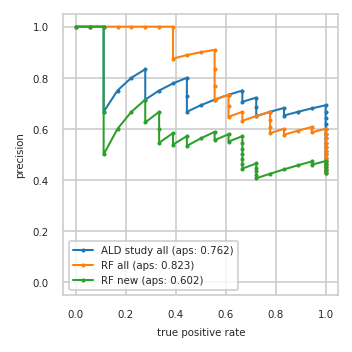

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.424 0.778
10         0.562 1.000     0.562 1.000     0.406 0.722
11         0.581 1.000     0.581 1.000     0.419 0.722
12         0.600 1.000     0.600 1.000     0.433 0.722
13         0.621 1.000     0.586 0.944     0.448 0.722
14         0.643 1.000     0.607 0.944     0.464 0.722
15         0.667 1.000     0.593 0.889     0.444 0.667
16         0.692 1.000     0.577 0.833     0.462 0.667
17         0.680 0.944     0.600 0.833     0.480 0.667
18         0.667 0.889     0.583 0.778     0.500 0.667
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.667 0.778     0.667 0.778     0.571 0.667
22         0.650 0.722     0.650 0.722     0.550 0.611
23         0.684 0.722     0.632 0.667     0.579 0.611
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.706 0.667     0.647 0.611     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.733 0.611     0.733 0.611     0.533 0.444
28         0.714 0.556     0.714 0.556     0.571 0.444
29         0.692 0.500     0.769 0.556     0.538 0.389
30         0.667 0.444     0.833 0.556     0.583 0.389
31         0.727 0.444     0.909 0.556     0.545 0.333
32         0.800 0.444     0.900 0.500     0.600 0.333
33         0.778 0.389     0.889 0.444     0.667 0.333
34         0.750 0.333     0.875 0.389     0.625 0.278
35         0.714 0.278     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


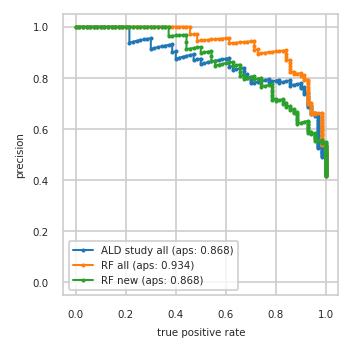

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


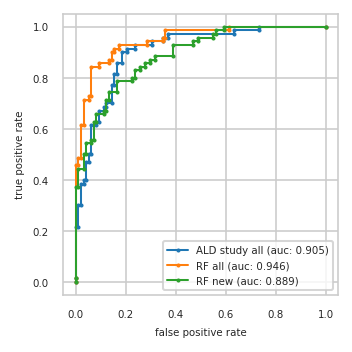

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}